In [ ]:
# load stategain model and then simulate adding noise in different ways to reproduce measured pop. statistics / noise correlations

In [1]:
from nems.xform_helper import load_model_xform
import nems.db as nd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 12

import sys
sys.path.append("/auto/users/hellerc/code/projects/nat_pupil_ms/")
from global_settings import CPN_SITES, HIGHR_SITES

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-03-13 064357.log


In [2]:
modelname = 'psth.fs4.pup-ld-st.pup-epcpn-hrc-psthfr.z-aev_stategain.SxR_tfinit.n.lr1e4.cont.et5.i50000'
site = "AMT020a"
batch = 331
cellid = [c for c in nd.get_batch_cells(batch).cellid if site in c][0]
xf, ctx = load_model_xform(cellid=cellid, batch=batch, modelname=modelname)

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT020a/psth.fs4.pup-ld-st.pup-epcpn-hrc-psthfr.z-aev.stategain.SxR.tfinit.n.lr1e4.cont....-5492761866588744812 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz to /auto/data/nems_db/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2

In [5]:
# adapt nems functions to apply noise -- take from nems_lbhb.modules.state.py
def indep_multiplicative(x, g, state, indep_noise):
    x = x * np.exp((g @ state[:g.shape[1],:]) * indep_noise)
    return x

def indep_additive(x, g, state, indep_noise):
    x = x + (g @ state[:g.shape[1],:]) * indep_noise
    return x

def shared_multiplicative(x, g, d, state, lv):
    x = x.copy()
    # faster(?): compute all scaling terms then apply at once (outside of loop)
    sf = np.zeros_like(x)
    for l in range(d.shape[1]):
        sf += (d[:,[l]] + g[:,[l]]*state[[l],:]) * lv[[l],:]
    
    x *= np.exp(sf)
    return x

def shared_additive(x, g, d, state, lv):
    x = x.copy()
    for l in range(d.shape[1]):
        x += (d[:,l:(l+1)] + g[:,l:(l+1)]*state[l:(l+1),:]) * lv[l:(l+1),:] 
    return x

In [5]:
# Perform factor analysis using just the pupil-dependent gain prediction. 
from sklearn.decomposition import FactorAnalysis
from charlieTools.nat_sounds_ms.decoding import load_site

X, sp_bins, X_pup, pup_mask, epochs = load_site(site=site, batch=int(batch), xforms_modelname=modelname, return_epoch_list=True)


[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/AMT020a_00f577ceb4f996132b73d081720e2cf5c38663f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
[root INFO] Extracting cellids: ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2', 'AMT020a-25-3', 'AMT020a-26-1', 'AMT020a-26-2', 'AMT020a-27-3', 'AMT020a-28-3', 'AMT020a-28-4

In [19]:
from charlieTools.nat_sounds_ms.preprocessing import fold_X, flatten_X

In [69]:
np.random.seed(123)
xflat = flatten_X(X)
pflat = flatten_X(X_pup)
pflat = (pflat - pflat.mean()) / pflat.std()
# Add indep. noise
inoise = np.random.normal(0, 1, xflat.shape)

# not pupil-dependent
ig = np.random.normal(2.5, 0.1, (xflat.shape[0], 1))
ig = ig / np.linalg.norm(ig)
xflat = indep_multiplicative(xflat, ig, pflat, inoise)

# pupil-dependent

# Add shared noise

# not pupil-dependent

# pupil-dependent

X = fold_X(xflat, nstim=X.shape[2], nreps=X.shape[1], nbins=X.shape[-1])

In [3]:
# define functions for calculating pop metrics
from scipy.signal import argrelextrema
def get_dim(LL):
    try:
        return argrelextrema(LL, np.greater)[0][0]+1
    except:
        print("No relative LL max, choosing overall maximum")
        return np.argmax(LL)+1

def sigma_shared(model):
    return (model.components_.T @ model.components_)

def get_dim95(model):
    """
    number of dims to explain 95% of shared var
    """
    ss = sigma_shared(model)
    evals, _ = np.linalg.eig(ss)
    evals = evals / sum(evals)
    return np.argwhere(np.cumsum(evals)>=0.95)[0][0]+1

def get_sv(model):
    sig_shared = sigma_shared(model) # rank n_components cov matrix
    full_cov_pred = sig_shared + np.diag(model.noise_variance_)
    # % shared variance
    # per neuron
    pn = np.diag(sig_shared) / np.diag(full_cov_pred)
    # average
    sv = np.mean(pn)
    return sv

def get_loading_similarity(model, dim=0):
    # loading similarity
    loading = model.components_[dim, :]
    loading /= np.linalg.norm(loading)
    load_sim = 1 - (np.var(loading) / (1 / len(loading)))
    return load_sim

## Perform FA on the simulated / modeled data

In [71]:
shuffle = False

# fit all stim together, after subtracting psth
# "special" cross-validation -- fitting individual stims doesn't work, not enough data
# instead, leave-one-stim out fitting to find dims that are shared / stimulus-independent
nstim = X.shape[-1] * X.shape[-2]
Xsub = (X - X.mean(axis=1, keepdims=True))
Xfa = Xsub.reshape(X.shape[0], X.shape[1], nstim)
pm = pup_mask.reshape(pup_mask.shape[0], pup_mask.shape[1], nstim)
if shuffle:
    pm = pm[:, np.random.choice(range(pup_mask.shape[1]), pup_mask.shape[1], replace=False), :]
nfold = nstim
nComponents = 20
if X.shape[0] < nComponents:
    nComponents = X.shape[0]

print("\nComputing log-likelihood across models / nfolds")
LL = np.zeros((20, nfold))
LL_small = np.zeros((20, nfold))
LL_large = np.zeros((20, nfold))
for ii in np.arange(1, LL.shape[0]+1):
    print(f"{ii} / {LL.shape[0]}")
    fa = FactorAnalysis(n_components=ii, random_state=0) # init model
    for nf in range(nfold):
        fit = [x for x in np.arange(0, nstim) if x != nf]

        # fit all data
        fa.fit(Xfa[:, :, fit].reshape(Xfa.shape[0], -1).T) # fit model
        # Get LL score
        LL[ii-1, nf] = fa.score(Xfa[:, :, nf].T)

        # fit large pupil
        fa.fit(Xfa[:, :, fit][:, pm[0, :, fit].T].reshape(Xfa.shape[0], -1).T) # fit model 
        LL_large[ii-1, nf] = fa.score(Xfa[:, pm[0, :, nf], nf].T)

        # fit small pupil
        fa.fit(Xfa[:, :, fit][:, pm[0, :, fit].T==False].reshape(Xfa.shape[0], -1).T) # fit model 
        LL_small[ii-1, nf] = fa.score(Xfa[:, pm[0, :, nf]==False, nf].T)


print("Estimating %sv and loading similarity for the 'best' model")
sp_dim_sem = np.std([get_dim(LL_small[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])
sp_dim = get_dim(LL_small.mean(axis=-1))
# fit the "best" model over jackknifes
sp_sv = np.zeros(nfold)
sp_loading_sim = np.zeros(nfold)
sp_dim95 = np.zeros(nfold)
for nf in range(nfold):
    fit = [x for x in np.arange(0, nstim) if x != nf]
    fa_small = FactorAnalysis(n_components=sp_dim, random_state=0) 
    fa_small.fit(Xfa[:, :, fit][:, pm[0, :, fit].T==False].T)
    sp_sv[nf] = get_sv(fa_small)
    sp_loading_sim[nf] = get_loading_similarity(fa_small)
    # get n dims needs to explain 95% of shared variance
    sp_dim95[nf] = get_dim95(fa_small)

bp_dim_sem = np.std([get_dim(LL_large[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])
bp_dim = get_dim(LL_large.mean(axis=-1))
# fit the "best" model over jackknifes
bp_sv = np.zeros(nfold)
bp_loading_sim = np.zeros(nfold)
bp_dim95 = np.zeros(nfold)
for nf in range(nfold):
    fit = [x for x in np.arange(0, nstim) if x != nf]
    fa_big = FactorAnalysis(n_components=bp_dim, random_state=0) 
    fa_big.fit(Xfa[:, :, fit][:, pm[0, :, fit].T==True].T)
    bp_sv[nf] = get_sv(fa_big)
    bp_loading_sim[nf] = get_loading_similarity(fa_big)
    # get n dims needs to explain 95% of shared variance
    bp_dim95[nf] = get_dim95(fa_big)


# final fit with all data to get components
fa_big = FactorAnalysis(n_components=bp_dim, random_state=0) 
fa_big.fit(Xfa[:, pm[0]==True].T)
bp_sv_all = get_sv(fa_big)
bp_ls_all = get_loading_similarity(fa_big)
bp_dim95_all = get_dim95(fa_big)

fa_small = FactorAnalysis(n_components=sp_dim, random_state=0) 
fa_small.fit(Xfa[:, pm[0]==False].T)
sp_sv_all = get_sv(fa_small)
sp_ls_all = get_loading_similarity(fa_small)
sp_dim95_all = get_dim95(fa_small)


Computing log-likelihood across models / nfolds
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Estimating %sv and loading similarity for the 'best' model
No relative LL max, choosing overall maximum
No relative LL max, choosing overall maximum


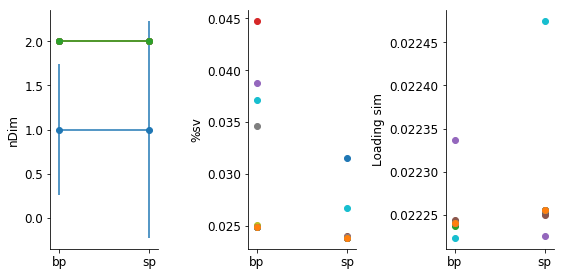

In [72]:
f, ax = plt.subplots(1, 3, figsize=(8, 4))


ax[0].errorbar([0, 1], [bp_dim, sp_dim], yerr=[bp_dim_sem, sp_dim_sem], marker="o")
ax[0].plot([0, 1], [bp_dim95, sp_dim95], marker="o")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["bp", "sp"])
ax[0].set_ylabel("nDim")
ax[0].set_xlim(-0.1, 1.1)

ax[1].plot([0, 1], [bp_sv, sp_sv], "o")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["bp", "sp"])
ax[1].set_ylabel("%sv")
ax[1].set_xlim(-0.1, 1.1)

ax[2].plot([0, 1], [bp_loading_sim, sp_loading_sim], "o")
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(["bp", "sp"])
ax[2].set_ylabel("Loading sim")
ax[2].set_xlim(-0.1, 1.1)

f.tight_layout()

In [14]:
#generate a "simulation" instead using the factor analysis model for this site
# then sweep across different matrices, generated using ddr utils
import dDR.utils.surrogate_helpers as sh
from loader import load_pop_metrics
results = load_pop_metrics(site=site, batch=batch, modelname="factor_analysis")
X, sp_bins, X_pup, pup_mask, epochs = load_site(site=site, batch=int(batch), return_epoch_list=True)


[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/AMT020a_00f577ceb4f996132b73d081720e2cf5c38663f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
[root INFO] Extracting cellids: ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2', 'AMT020a-25-3', 'AMT020a-26-1', 'AMT020a-26-2', 'AMT020a-27-3', 'AMT020a-28-3', 'AMT020a-28-4

In [15]:
results["final_fit"].keys()

dict_keys(['fa_big.components_', 'fa_small.components_', 'fa_big.sigma_shared', 'fa_small.sigma_shared', 'fa_big.sigma_full', 'fa_small.sigma_full', 'bp_sv_all', 'sp_sv_all', 'bp_ls_all', 'sp_ls_all', 'bp_dim95_all', 'sp_dim95_all'])

In [24]:
psth_big = fold_X(X[:, pup_mask[0]==True], nstim=X.shape[2], nreps=int(X.shape[1]/2), nbins=X.shape[-1])
psth_big.shape


(45, 50, 4, 3)

In [25]:
np.random.seed(123)
psth_big = fold_X(X[:, pup_mask[0]==True], nstim=X.shape[2], nreps=int(X.shape[1]/2), nbins=X.shape[-1]).mean(axis=1).reshape(X.shape[0], -1)
psth_small = fold_X(X[:, pup_mask[0]==False], nstim=X.shape[2], nreps=int(X.shape[1]/2), nbins=X.shape[-1]).mean(axis=1).reshape(X.shape[0], -1)
Xsim_big = np.zeros((X.shape[0], 1000, X.shape[2]*X.shape[3]))
Xsim_small = np.zeros((X.shape[0], 1000, X.shape[2]*X.shape[3]))
cov_big = results["final_fit"]["fa_big.sigma_full"]
cov_small = results["final_fit"]["fa_small.sigma_full"]

# generate cov matrices with different pop. metrics
# high loading similarity, two dimensions, low shared variance
lvs = np.hstack([sh.generate_lv_loading(X.shape[0], mean_loading=2.5, variance=0.1, mag=1) for i in range(2)])
lvs = sh.orthonormal(lvs)
cov_small = sh.generate_full_rank_cov(lvs)
cov_big = sh.generate_full_rank_cov(lvs)
np.fill_diagonal(cov_big, np.diag(cov_big)*1.05) # lots of ind. variance
np.fill_diagonal(cov_small, np.diag(cov_small)*0.95) # little ind. variance
for s in range(psth_big.shape[-1]):
    Xsim_big[:, :, s]= np.random.multivariate_normal(psth_big[:, s], cov=cov_big, size=Xsim_big.shape[1]).T
    Xsim_small[:, :, s]= np.random.multivariate_normal(psth_small[:, s], cov=cov_small, size=Xsim_big.shape[1]).T

/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


In [26]:
psth_big.shape

(45, 12)

In [27]:
fa_sim = {
    "big": {},
    "small": {}
}
for key, X in zip(["big", "small"], [Xsim_big, Xsim_small]):
    nstim = X.shape[-1]
    Xsub = (X - X.mean(axis=1, keepdims=True))
    Xfa = Xsub
    nfold = nstim
    nComponents = 20
    if X.shape[0] < nComponents:
        nComponents = X.shape[0]

    print("\nComputing log-likelihood across models / nfolds")
    LL = np.zeros((20, nfold))
    for ii in np.arange(1, LL.shape[0]+1):
        print(f"{ii} / {LL.shape[0]}")
        fa = FactorAnalysis(n_components=ii, random_state=0) # init model
        for nf in range(nfold):
            fit = [x for x in np.arange(0, nstim) if x != nf]

            # fit all data
            fa.fit(Xfa[:, :, fit].reshape(Xfa.shape[0], -1).T) # fit model
            # Get LL score
            LL[ii-1, nf] = fa.score(Xfa[:, :, nf].T)


    print("Estimating %sv and loading similarity for the 'best' model")
    dim_sem = np.std([get_dim(LL[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])
    dim = get_dim(LL.mean(axis=-1))
    # fit the "best" model over jackknifes
    sv = np.zeros(nfold)
    loading_sim = np.zeros(nfold)
    dim95 = np.zeros(nfold)
    for nf in range(nfold):
        fit = [x for x in np.arange(0, nstim) if x != nf]
        fa = FactorAnalysis(n_components=dim, random_state=0) 
        fa.fit(Xfa[:, :, fit].reshape(Xfa.shape[0], -1).T)
        sv[nf] = get_sv(fa)
        loading_sim[nf] = get_loading_similarity(fa)
        # get n dims needs to explain 95% of shared variance
        dim95[nf] = get_dim95(fa)

    # final fit with all data to get components
    fa = FactorAnalysis(n_components=dim, random_state=0) 
    fa.fit(Xfa.reshape(Xfa.shape[0], -1).T)
    sv_all = get_sv(fa)
    ls_all = get_loading_similarity(fa)
    dim95_all = get_dim95(fa)

    fa_sim[key]["sv"] = sv.mean()
    fa_sim[key]["loading_sim"] = loading_sim.mean()
    fa_sim[key]["dim"] = dim95.mean()
    fa_sim[key]["sv_all"] = sv_all
    fa_sim[key]["loading_sim_all"] = ls_all
    fa_sim["dim_all"] = dim95_all


Computing log-likelihood across models / nfolds
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Estimating %sv and loading similarity for the 'best' model

Computing log-likelihood across models / nfolds
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Estimating %sv and loading similarity for the 'best' model


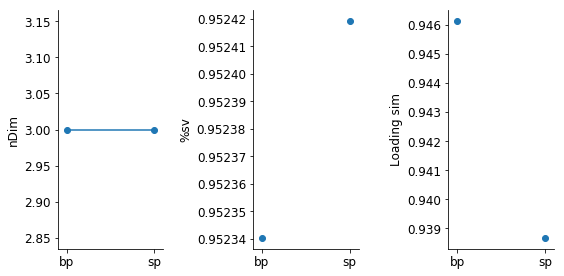

In [28]:
f, ax = plt.subplots(1, 3, figsize=(8, 4))


ax[0].plot([0, 1], [fa_sim["big"]["dim"], fa_sim["small"]["dim"]], marker="o")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["bp", "sp"])
ax[0].set_ylabel("nDim")
ax[0].set_xlim(-0.1, 1.1)

ax[1].plot([0, 1], [fa_sim["big"]["sv"], fa_sim["small"]["sv"]], "o")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["bp", "sp"])
ax[1].set_ylabel("%sv")
ax[1].set_xlim(-0.1, 1.1)

ax[2].plot([0, 1], [fa_sim["big"]["loading_sim"], fa_sim["small"]["loading_sim"]], "o")
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(["bp", "sp"])
ax[2].set_ylabel("Loading sim")
ax[2].set_xlim(-0.1, 1.1)

f.tight_layout()

In [156]:
evals, _ = np.linalg.eig(np.cov(Xsub.reshape(Xsub.shape[0], -1)))
plt.plot(evals, "o-")